In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date, timedelta
from nsepy import get_history  # package to get the data from nse
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
pip install nsepy

  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36084 sha256=b5111e864168142707cd96ce260ce7b647ac7095982d64e8137daceb958fb148
  Stored in directory: /root/.cache/pip/wheels/32/ab/d9/78ceea14cdf6de83376082b3cb0c2999fd77f823e35c47b9ec
Successfully built nsepy


In [28]:
# User defined function get the data from nse

def getnsedata(comp_name):
    data = get_history(symbol=comp_name,
                       start=date(2016, 1, 1),
                       end=date.today())
    return data

In [29]:
#data
df = getnsedata("SBIN")
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2016-01-01,SBIN,EQ,224.45,225.00,228.90,224.50,227.75,227.80,226.94,6449426,1.463601e+14,49529,1376633,0.2135
2016-01-04,SBIN,EQ,227.80,226.95,226.95,220.05,221.10,220.70,222.80,14092071,3.139744e+14,113875,5337291,0.3787
2016-01-05,SBIN,EQ,220.70,222.80,222.80,217.00,217.75,217.75,219.46,15074848,3.308362e+14,137290,6241116,0.4140
2016-01-06,SBIN,EQ,217.75,217.90,219.90,216.40,217.00,216.85,218.00,11921123,2.598852e+14,96992,3750530,0.3146
2016-01-07,SBIN,EQ,216.85,214.00,214.10,209.00,209.75,209.55,210.81,14342279,3.023488e+14,131516,5943545,0.4144


In [30]:
df1=df.reset_index()['Close']

In [31]:
df1

0       227.80
1       220.70
2       217.75
3       216.85
4       209.55
         ...  
1505    538.30
1506    532.30
1507    539.80
1508    540.10
1509    530.30
Name: Close, Length: 1510, dtype: float64

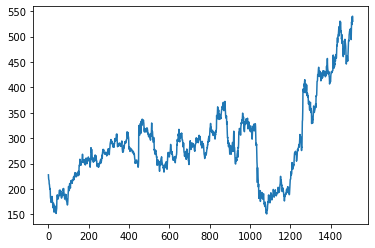

In [32]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [34]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [35]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [36]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [37]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [38]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [39]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 23s 401ms/step - loss: 0.0302 - val_loss: 0.0530
Epoch 2/100
14/14 [==============================] - 3s 236ms/step - loss: 0.0042 - val_loss: 0.0221
Epoch 3/100
14/14 [==============================] - 3s 236ms/step - loss: 0.0024 - val_loss: 0.0231
Epoch 4/100
14/14 [==============================] - 3s 236ms/step - loss: 0.0021 - val_loss: 0.0207
Epoch 5/100
14/14 [==============================] - 3s 242ms/step - loss: 0.0019 - val_loss: 0.0176
Epoch 6/100
14/14 [==============================] - 3s 234ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 7/100
14/14 [==============================] - 3s 237ms/step - loss: 0.0017 - val_loss: 0.0086
Epoch 8/100
14/14 [==============================] - 3s 234ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 9/100
14/14 [==============================] - 3s 242ms/step - loss: 0.0016 - val_loss: 0.0065
Epoch 10/100
14/14 [==============================] - 3s 233ms/step - loss: 0.0015 - val_l

In [42]:
import tensorflow as tf

In [43]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [44]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [47]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

283.96865011203323

In [46]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))


359.8793141021771

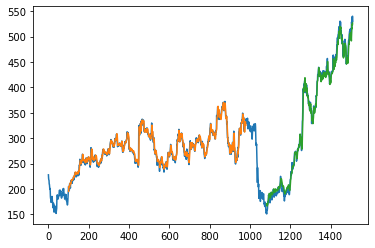

In [48]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [49]:
len(test_data)

529

In [51]:
x_input=test_data[429:].reshape(1,-1)
x_input.shape

(1, 100)

In [52]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [53]:
temp_input

[0.7248554913294798,
 0.7527296082209378,
 0.8037251123956326,
 0.7790622992935132,
 0.7362877328195248,
 0.7397559409120102,
 0.7398843930635839,
 0.7680154142581888,
 0.7447655748233784,
 0.7597944765574824,
 0.7554271034039819,
 0.7942196531791907,
 0.7762363519588953,
 0.7727681438664096,
 0.8023121387283236,
 0.8062941554271033,
 0.7870263326910725,
 0.7888246628131019,
 0.7890815671162492,
 0.8179833012202955,
 0.8533076429030186,
 0.8499678869621066,
 0.8728323699421965,
 0.8917148362235066,
 0.8666666666666667,
 0.8967244701348747,
 0.9045600513808605,
 0.9045600513808605,
 0.9136801541425819,
 0.9292228644829799,
 0.946178548490687,
 0.9004495825305074,
 0.902504816955684,
 0.9373153500321132,
 0.9527296082209378,
 0.9680154142581887,
 0.975208734746307,
 0.9567116249197174,
 0.9718689788053949,
 0.9596660244059088,
 0.9216441875401413,
 0.9261400128452151,
 0.9138086062941555,
 0.8843930635838151,
 0.8922286448298007,
 0.9067437379576109,
 0.8620423892100191,
 0.8791265253692

In [54]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.95513797]
101
1 day input [0.75272961 0.80372511 0.7790623  0.73628773 0.73975594 0.73988439
 0.76801541 0.74476557 0.75979448 0.7554271  0.79421965 0.77623635
 0.77276814 0.80231214 0.80629416 0.78702633 0.78882466 0.78908157
 0.8179833  0.85330764 0.84996789 0.87283237 0.89171484 0.86666667
 0.89672447 0.90456005 0.90456005 0.91368015 0.92922286 0.94617855
 0.90044958 0.90250482 0.93731535 0.95272961 0.96801541 0.97520873
 0.95671162 0.97186898 0.95966602 0.92164419 0.92614001 0.91380861
 0.88439306 0.89222864 0.90674374 0.86204239 0.87912653 0.87938343
 0.87270392 0.82119461 0.80732177 0.79563263 0.83352601 0.83789338
 0.82800257 0.80783558 0.83712267 0.87527296 0.86782274 0.88336545
 0.86563905 0.86756583 0.85793192 0.84855491 0.81425819 0.76647399
 0.75825305 0.78355812 0.79884393 0.78638407 0.78921002 0.7973025
 0.77983301 0.7728966  0.79537572 0.82196532 0.85459216 0.87745665
 0.87565832 0.87450225 0.90635838 0.91226718 0.92331407 0.92614001
 0.91843288 0.93294798 0.91445087 

In [55]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)


In [56]:
len(df1)

1510

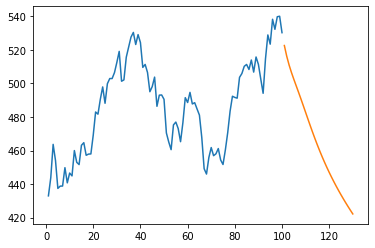

In [57]:
plt.plot(day_new,scaler.inverse_transform(df1[1410:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

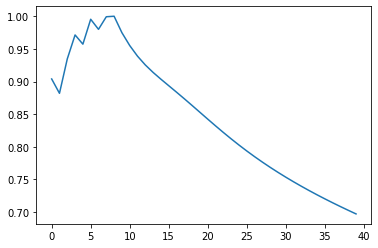

In [60]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1500:])

In [61]:
df3=scaler.inverse_transform(df3).tolist()

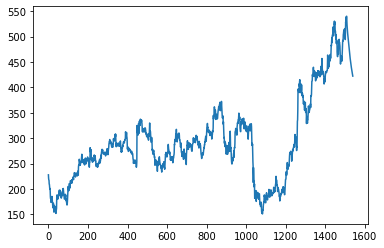

In [62]:
plt.plot(df3)